In [3]:
import re, json, os
import nltk, pickle
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.preprocessing import LabelEncoder

import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Flatten, Bidirectional, GRU, BatchNormalization

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to C:\Users\MY
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\MY
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\MY
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\MY
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Importing the data

In [4]:
#importing the dataset
with open('content.json') as content:
    data1 = json.load(content)

In [5]:
#getting all the data to lists
tags = []
inputs = []
responses={}
for intent in data1["intents"]:
    responses[intent['tag']]=intent['responses']
    for lines in intent['input']:
        inputs.append(lines)
        tags.append(intent['tag'])

In [6]:
#converting to dataframe
data = pd.DataFrame({"inputs":inputs,
                    "tags":tags})

In [7]:
#printing the data
data

,inputs,tags
0,Bye,goodbye
1,See you later,goodbye
2,Goodbye,goodbye
3,byye,goodbye
4,byee,goodbye
...,...,...
1743,it's brutal,crule_world
1744,devilish people,crule_world
1745,people are so mean,crule_world
1746,crule_word,crule_world


In [8]:
data = data.sample(frac=1)

Pre-Processing 

In [9]:
lemmatizer = WordNetLemmatizer()
nltk_tokenizer = RegexpTokenizer(r'\w+')
stopwords_list = stopwords.words('english')
print(stopwords_list)

def lemmatization(lemmatizer,sentence):
    lem = [lemmatizer.lemmatize(k) for k in sentence]
    return [k for k in lem if k]

def remove_stop_words(stopwords_list,sentence):
    return [k for k in sentence if k not in stopwords_list]

def preprocess_one(chat):
    chat = chat.lower()
    remove_punc = nltk_tokenizer.tokenize(chat) # Remove puntuations
    remove_num = [re.sub('[0-9]', '', i) for i in remove_punc] # Remove Numbers
    remove_num = [i for i in remove_num if len(i)>0] # Remove empty strings
    lemmatized = lemmatization(lemmatizer,remove_num) # Word Lemmatization
    remove_stop = remove_stop_words(stopwords_list,lemmatized) # remove stop words
    updated_chat = ' '.join(remove_stop)
    return updated_chat

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [10]:
#removing punctuations
import string
data['inputs'] = data['inputs'].apply(lambda chat:preprocess_one(chat)) # Follow Tutorial
data

,inputs,tags
285,funny,agent_funny
821,wonderful,appraisal_good
886,anything want,appraisal_welcome
1413,well special,user_likes_agent
554,yes would like,confirmation_yes
...,...,...
709,bad,appraisal_bad
1607,talk plz,user_want_to_talk
10,thank lot,thanks
777,bad,appraisal_good


In [11]:
def vis_length_variation(X_SEQ):
    X_len = [len(i) for i in X_SEQ]
    X_len = pd.Series(X_len)
    X_len.hist()
    plt.xlabel('Token Length')
    plt.ylabel('Samples')
    plt.savefig('vis/sequence length.png')
    plt.show()
    
    print(X_len.describe())

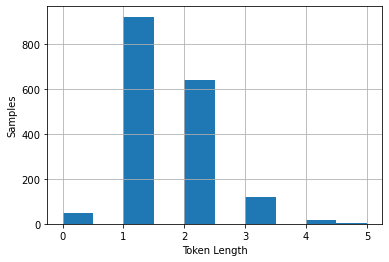

count    1748.000000
mean        1.509725
std         0.725224
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         5.000000
dtype: float64


In [12]:
#tokenize the data & pad
max_length = 5
tokenizer_path = 'weights/TOKENIZER.pkl'
encoder_path = 'weights/ENCODER.pkl'

if not os.path.exists(tokenizer_path):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<oov>')
    tokenizer.fit_on_texts(data['inputs'])

    with open(tokenizer_path, 'wb') as fp:
        pickle.dump(tokenizer, fp, protocol=pickle.HIGHEST_PROTOCOL)

else:
    with open(tokenizer_path, 'rb') as fp:
        tokenizer = pickle.load(fp)
                
X_SEQ = tokenizer.texts_to_sequences(data['inputs'])
vis_length_variation(X_SEQ)
X_PAD = tf.keras.preprocessing.sequence.pad_sequences(
                                            X_SEQ, 
                                            maxlen=max_length, 
                                            padding='pre', 
                                            truncating='pre'
                                            )# Pad Train data

#output encoding
if not os.path.exists(encoder_path):
    encoder = LabelEncoder()
    encoder.fit(data['tags'])
    
    with open(encoder_path, 'wb') as fp:
        pickle.dump(encoder, fp, protocol=pickle.HIGHEST_PROTOCOL)

else:
    with open(encoder_path, 'rb') as fp:
        encoder = pickle.load(fp)

y_train = encoder.transform(data['tags'])

In [13]:
#define vocabulary
vocabulary = tokenizer.word_index
# vocabulary

# Neural Network

In [14]:
#creating the model
embedding_dim = 100 # Size of the Vector assign for each word
vocab_size = len(vocabulary) + 1 # No of unique words
output_dim = len(set(y_train)) # No of Tags

inputs = Input(shape=(max_length,), name='chat_inputs')
embedding_layer = Embedding(
                        output_dim = embedding_dim, 
                        input_dim = vocab_size, 
                        input_length = max_length, 
                        name = 'embedding'
                            )
gru_layer1 = Bidirectional(
                        GRU(
                            128,
                            unroll=True,
                            return_sequences = True # Follow a tutorial
                            )
                        )
gru_layer2 = Bidirectional(
                        GRU(
                            64,
                            unroll=True
                            )
                        )

dense_layer1 = Dense(128)
dense_layer2 = Dense(64)

batchnorm_layer1 = BatchNormalization()
batchnorm_layer2 = BatchNormalization()

relu_layer = relu
dropout_layer = Dropout(0.2)
output_layer = Dense(output_dim,activation="softmax")

x = embedding_layer(inputs)
x = gru_layer1(x)
x = gru_layer2(x)

x = dense_layer1(x)
x = batchnorm_layer1(x)
x = relu_layer(x)
x = dropout_layer(x)

x = dense_layer2(x)
x = batchnorm_layer2(x)
x = relu_layer(x)
x = dropout_layer(x)

outputs = output_layer(x)
model = Model(inputs,outputs)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
chat_inputs (InputLayer)        [(None, 5)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5, 100)       56900       chat_inputs[0][0]                
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 5, 256)       176640      embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 128)          123648      bidirectional[0][0]              
_______________________________________________________________________________________

In [15]:
#compile the model
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [16]:
#training the model
train = model.fit(X_PAD, y_train,epochs=200,validation_split = 0.15)

Epoch 1/200
47/47 [==============================] - 2s 35ms/step - loss: 4.2066 - accuracy: 0.1441 - val_loss: 4.6266 - val_accuracy: 0.0875
Epoch 2/200
47/47 [==============================] - 1s 18ms/step - loss: 3.1943 - accuracy: 0.3327 - val_loss: 4.5267 - val_accuracy: 0.0875
Epoch 3/200
47/47 [==============================] - 1s 18ms/step - loss: 2.6500 - accuracy: 0.4397 - val_loss: 4.4125 - val_accuracy: 0.0913
Epoch 4/200
47/47 [==============================] - 1s 19ms/step - loss: 2.2636 - accuracy: 0.5367 - val_loss: 4.2532 - val_accuracy: 0.1331
Epoch 5/200
47/47 [==============================] - 1s 19ms/step - loss: 1.8999 - accuracy: 0.6061 - val_loss: 4.1120 - val_accuracy: 0.1103
Epoch 6/200
47/47 [==============================] - 1s 18ms/step - loss: 1.6269 - accuracy: 0.6673 - val_loss: 3.8912 - val_accuracy: 0.1939
Epoch 7/200
47/47 [==============================] - 1s 19ms/step - loss: 1.4219 - accuracy: 0.7104 - val_loss: 3.6848 - val_accuracy: 0.2662
Epoch 

47/47 [==============================] - 1s 21ms/step - loss: 0.3860 - accuracy: 0.8640 - val_loss: 2.0012 - val_accuracy: 0.6008
Epoch 59/200
47/47 [==============================] - 1s 20ms/step - loss: 0.4025 - accuracy: 0.8613 - val_loss: 1.9047 - val_accuracy: 0.6464
Epoch 60/200
47/47 [==============================] - 3s 72ms/step - loss: 0.3980 - accuracy: 0.8599 - val_loss: 1.8995 - val_accuracy: 0.6502
Epoch 61/200
47/47 [==============================] - 2s 44ms/step - loss: 0.3804 - accuracy: 0.8687 - val_loss: 1.9189 - val_accuracy: 0.6388
Epoch 62/200
47/47 [==============================] - 2s 44ms/step - loss: 0.3962 - accuracy: 0.8586 - val_loss: 1.9886 - val_accuracy: 0.6274
Epoch 63/200
47/47 [==============================] - 1s 25ms/step - loss: 0.3796 - accuracy: 0.8694 - val_loss: 2.0284 - val_accuracy: 0.6388
Epoch 64/200
47/47 [==============================] - 2s 48ms/step - loss: 0.3914 - accuracy: 0.8593 - val_loss: 2.0227 - val_accuracy: 0.6198
Epoch 65/200

47/47 [==============================] - 1s 19ms/step - loss: 0.3384 - accuracy: 0.8640 - val_loss: 2.1935 - val_accuracy: 0.6312
Epoch 116/200
47/47 [==============================] - 1s 20ms/step - loss: 0.3382 - accuracy: 0.8721 - val_loss: 2.0261 - val_accuracy: 0.6578
Epoch 117/200
47/47 [==============================] - 1s 20ms/step - loss: 0.3495 - accuracy: 0.8599 - val_loss: 2.2727 - val_accuracy: 0.6350
Epoch 118/200
47/47 [==============================] - 1s 19ms/step - loss: 0.3490 - accuracy: 0.8700 - val_loss: 2.1256 - val_accuracy: 0.6350
Epoch 119/200
47/47 [==============================] - 1s 19ms/step - loss: 0.3519 - accuracy: 0.8640 - val_loss: 2.4518 - val_accuracy: 0.6274
Epoch 120/200
47/47 [==============================] - 1s 21ms/step - loss: 0.3645 - accuracy: 0.8579 - val_loss: 2.0776 - val_accuracy: 0.6578
Epoch 121/200
47/47 [==============================] - 1s 24ms/step - loss: 0.3523 - accuracy: 0.8579 - val_loss: 2.3045 - val_accuracy: 0.6426
Epoch 

Epoch 172/200
47/47 [==============================] - 1s 21ms/step - loss: 0.3407 - accuracy: 0.8727 - val_loss: 2.3537 - val_accuracy: 0.6388
Epoch 173/200
47/47 [==============================] - 1s 21ms/step - loss: 0.3245 - accuracy: 0.8721 - val_loss: 2.4714 - val_accuracy: 0.6502
Epoch 174/200
47/47 [==============================] - 1s 20ms/step - loss: 0.3133 - accuracy: 0.8761 - val_loss: 2.2863 - val_accuracy: 0.6426
Epoch 175/200
47/47 [==============================] - 1s 20ms/step - loss: 0.3248 - accuracy: 0.8714 - val_loss: 2.3628 - val_accuracy: 0.6502
Epoch 176/200
47/47 [==============================] - 1s 20ms/step - loss: 0.3163 - accuracy: 0.8795 - val_loss: 2.3891 - val_accuracy: 0.6312
Epoch 177/200
47/47 [==============================] - 1s 18ms/step - loss: 0.3244 - accuracy: 0.8660 - val_loss: 2.4573 - val_accuracy: 0.6426
Epoch 178/200
47/47 [==============================] - 1s 17ms/step - loss: 0.3326 - accuracy: 0.8754 - val_loss: 2.6873 - val_accuracy:

In [17]:
model.save('weights/SUICIDE-BOT.h5')

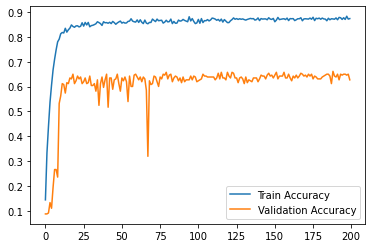

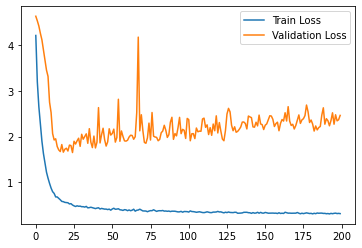

In [18]:
#plotting model accuracy
plt.plot(train.history['accuracy'],label='Train Accuracy')
plt.plot(train.history['val_accuracy'],label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(train.history['loss'],label='Train Loss')
plt.plot(train.history['val_loss'],label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
#chatting
import random

while True:
    prediction_input = input('You : ')
    
    #removing punctuation and converting to lowercase
    prediction_input = preprocess_one(prediction_input)
    prediction_input = tokenizer.texts_to_sequences([prediction_input])
    prediction_input = tf.keras.preprocessing.sequence.pad_sequences(
                                                                prediction_input, 
                                                                maxlen=max_length, 
                                                                padding='pre', 
                                                                truncating='pre'
                                                                )# Pad Train data
    
    #getting output from model
    output = model.predict(prediction_input)
    output = output.argmax()
    
    #finding the right tag and predicting
    response_tag = encoder.inverse_transform([output])[0]
    print("HelpingBot : ",random.choice(responses[response_tag]))
    if response_tag == "goodbye":
        break

You : hi
HelpingBot :  Hi there, friend!
You : i feel alone
HelpingBot :  Let's have a small chat then.
You : im so sad
HelpingBot :  If you're feeling down, how about drawing or painting something?
You : i dont think so
HelpingBot :  Good!
You : Mmmmm
HelpingBot :  Great!
